<a href="https://colab.research.google.com/github/srivatsan1991/econ/blob/main/Savings_%26_Liquidity_Constraints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Savings and Liquidy Constraints" (Author: Angus Deaton)

## Brief Notes:

This notebook simply implements the recursion presented in Eq (10) of the paper by Deaton ([link](https://www.princeton.edu/~deaton/downloads/Saving_and_Liquidity_Constraints.pdf))
$$
p_n(x) = \text{max}\left( \lambda(x), \beta \int p_{n-1} \left[ (1+r)(x - \lambda^{-1}(p_{n-1}(x))) + y \right] dF(y) \right) 
$$

*(there is actually a typo in the RHS in the paper.. It should be $p_{n-1}$ instead of $p_n$ which we have corrected here)*.

Starting from $p_0(x) = \lambda(x)$ (say) and iterating a bunch of times, we expect this recursion to converge to the optimal $p(x)$. 

Some meanings of the variables (for convenience):
- $x$ is the cash in hand
- $f(x)$ is the optimal consumption given $x$ cash in hand.
- $p(x) = \lambda(f(x))$ is the marginal utility evaluated at the optimal consumption assuming that the cash in hand is $x$.
- Consequently $f(x) = \lambda^{-1}(p(x))$ and so we can obtain the optimal consumption once we know $p(x)$.
- The first term in the above maximization expresses the liquidity constraint. You can never consume more than all the cash in hand, and so the marginal utility can never fall below $\lambda(x)$ (hence the maximization).
- The second term is the discounted expected marginal utility evaluated at the optimal consumption at $t+1$. The discounting is by $\beta = \frac{1 + r}{1+\delta}$, where $r$ is the rate of return and $\delta$ is the impatience rate. 

In words this is what is going on in the above equation:
At time $t$ there is one decision to be made which is $c_t$, i.e., how much you should consume. You make that decision so that the discounted expected marginal utility evaluated at $c_{t+1}$ is the same as the marginal utility evaluated at $c_t$ if permitted by liquidity constraint ($x_{t} \geq 0$). If not, you are constrained to spend exactly $x_{t}$ and live hand to mouth. 

This solution method which defines and computes $p(x)$ is a fairly beautiful way of dealing with the problem by appealing to marginal utility (and figuring out the correct discounting etc). 

Instead, you can always just setup the value function and its recursion and solve it the usual way. Deaton actually discusses how/why these approaches are equivalent in the paragraph after Eq (12).

## The implementation:

We take the same values for the parameters as in the paper.

- $y \sim N(\mu, \sigma)$ with $\mu = 100, \sigma=10,15$.
(This part of the simulation is a bit problematic since according to this income can be negative albeit with an ignorably tiny probability (10^-20 or so in this case) so we can ignore negative $y$ when doing the integration.

- the $\lambda(c) = c^{-\rho}$ with $\rho = 2,3$.

- $ r = .05, \delta = .10 $.

The key part of the simulation is doing the integral over the income distribution - which we do by a naive monte carlo. 

In [1]:
import numpy as np
from scipy import optimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [40]:
def deaton_plot(rho = 2, mu = 100, sigma = 15 ,r = .05, delta = .1):

  beta = (1 + r)/(1 + delta)

  def lmbda(x):
    return x ** (-rho)


  def lmbdainv(y, a=0,b=10000):
    def fun(x):
      return -y + lmbda(x)
    return optimize.bisect(fun, a-y, b-y)


  def iterate(X, p_old, n_sample = 1000):
    p_new = []
    p_old_interp = interp1d(X, p_old, fill_value="extrapolate")

    for i, x in enumerate(X):
      Y = np.random.normal(mu, sigma, n_sample)
    
      # \beta \int p_{n-1}{(1+r)(x - \lambda^{-1}(p_{n-1}(x))) + y} dF(y) 
      future_p = [beta * p_old_interp((1+r) * (x - lmbdainv(p_old[i])) + y) for y in Y]
      p_new.append(np.max([lmbda(x), np.mean(future_p)]))

    return np.array(p_new)

  plt.xlim([mu - 2 * sigma, mu + 1.4*sigma])
  plt.ylim([mu - 2 * sigma, mu + 1.4*sigma])

  XX = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 20)
  PP = lmbda(XX)

  for i in range(14): 
    PP = iterate(XX, PP)
  plt.plot(XX,[lmbdainv(y) for y in PP], label=f'rho={rho}, mu={mu}, sigma={sigma} ,r={r}, delta={delta}')

  plt.legend()
  plt.xlabel('income + assets')
  plt.ylabel('immediate consumption')

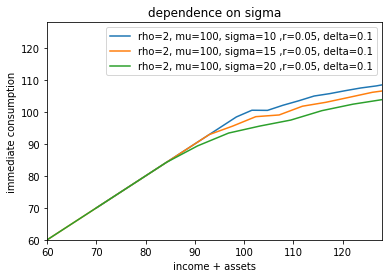

In [38]:
deaton_plot(sigma= 10)
deaton_plot(sigma=15)
deaton_plot(sigma=20)
plt.title('dependence on sigma')
plt.show()

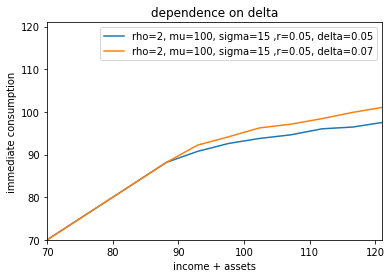

In [43]:
deaton_plot(delta = .05)
deaton_plot(delta = .07)
plt.title('dependence on delta')
plt.show()